### Version Info

In [940]:
import sklearn
version = !python -V
print("This notebook uses %s" % version[0])
print("This notebook uses sklearn version %s" % sklearn.__version__)

This notebook uses Python 3.9.12
This notebook uses sklearn version 1.0.2


### Import

In [941]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [942]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [943]:
import warnings
warnings.filterwarnings("ignore")

### Functions

In [944]:
def Stacked_Bar_Chart(data_HA, attribute_name):
    
    ''' The fubction depicts Stacked Bar Chart using Seaborn'''
    
    ## prep data:
    df_counts = data_HA.groupby([attribute_name])['output'].agg('count').reset_index(name="Count")
    df_counts_output = data_HA.groupby([attribute_name, 'output'])['age'].agg('count').reset_index(name="Count")
    df_counts_output1 = df_counts_output.loc[df_counts_output.output == 1]
    
    #print(df_counts_output)
    
    ## prep graph:
    
    # set general plot properties
    sns.set_style("white")
    sns.set_context({"figure.figsize": (6, 5)})
  
    # plot 1 - background - "total" (top) series
    total_plot = sns.barplot(x = df_counts[attribute_name], y = df_counts.Count, color = "red")
    total_plot.set(ylim=(0, 250))

    # plot 2 - overlay - "bottom" series
    bottom_plot = sns.barplot(x = df_counts_output1[attribute_name], y = df_counts_output1.Count, color = "#0000A3")
    
    # legend
    #topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
    #bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
    #l = plt.legend([bottombar, topbar], ['output 1', 'output 0'], loc='upper left', ncol = 1, prop={'size':14}, bbox_to_anchor=(1.02, 1))    # ['output 1 - No HA', 'output 0 - Yes HA']
    #l.draw_frame(False)

    #Optional code - Make plot look nicer
    sns.despine(left=True)
    bottom_plot.set_ylabel("Count")
    bottom_plot.set_xlabel(attribute_name)

In [945]:
def correlation_test(df):
    
    '''This function calculates the coefficients and p-values for spearman's correlation test on every feature combination'''
    ''' Source: https://developer.ibm.com/articles/statistical-significance-testing-explained-with-examples-in-python/ '''
        
    spearman_stat = df.corr(method=lambda x, y: stats.spearmanr(x, y)[0])
    spearman_p = df.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
    spearman_p = (spearman_p - np.eye(df.shape[1])).round(4)

    return spearman_stat, spearman_p

In [946]:
def save_correlation_map(stat, p_values, save_name, title):
    
    '''This function uses the the seaborn correlation heatmap to visualize the coefficients and p-values for each pairewise test'''
    ''' Source: https://developer.ibm.com/articles/statistical-significance-testing-explained-with-examples-in-python/ '''
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    sns.heatmap(stat, annot=True, ax=axes[0])
    sns.heatmap(p_values, annot=True, ax=axes[1])
    axes[0].set_title(title + ' - Coefficients', fontsize=20, pad=10)
    axes[1].set_title(title + ' - P-values', fontsize=20, pad=10)
    plt.savefig(save_name, dpi=300, bbox_inches='tight')

### Load Data

In [947]:
data_HA = pd.read_csv("AwakeLabs-Dataset.csv")

### EDA & Data Cleaning 

In [948]:
data_HA.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,o2Saturation
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0,98.6
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0,98.6


In [949]:
data_HA.tail(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,o2Saturation
3584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.6
3585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.6


In [950]:
print(data_HA.shape)
data_HA.info()

(3586, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    float64
 1   sex           303 non-null    float64
 2   cp            303 non-null    float64
 3   trtbps        303 non-null    float64
 4   chol          303 non-null    float64
 5   fbs           303 non-null    float64
 6   restecg       303 non-null    float64
 7   thalachh      303 non-null    float64
 8   exng          303 non-null    float64
 9   oldpeak       303 non-null    float64
 10  slp           303 non-null    float64
 11  caa           303 non-null    float64
 12  thall         303 non-null    float64
 13  output        303 non-null    float64
 14  o2Saturation  3586 non-null   float64
dtypes: float64(15)
memory usage: 420.4 KB


#### 1. Reorder columns to indicate the dataset is labled:

As per the Data Dictionary given in file: Awake Labs Data Scientist - Take Home Challenge.pdf ....
I am going to move the "output" column to the end of the dataframe to indicate this is the target variable, namely, the label / class.

In [951]:
col_output = data_HA.pop('output')
data_HA = pd.concat([data_HA, col_output], axis = 1)

In [952]:
print(data_HA.columns)

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'o2Saturation', 'output'],
      dtype='object')


#### 2. Remove empty data:

As can be seen in the EDA above all attributes but o2Saturation (i.e.,oxygen saturation) have 303 non-null records while the latter has 3586 non-null values. 

An oxygen saturation level is the measurement for the amount of oxygen in one's bloodstream. We know from the literature that o2Saturation as a stand-alone measurement is not able to predice a heart attack. Therefore, I am going to remove all rows where o2Saturation is not null but other columns are. 

In [953]:
# Check for null values:
data_HA.isnull().sum()

age             3283
sex             3283
cp              3283
trtbps          3283
chol            3283
fbs             3283
restecg         3283
thalachh        3283
exng            3283
oldpeak         3283
slp             3283
caa             3283
thall           3283
o2Saturation       0
output          3283
dtype: int64

In [954]:
# simplest solution: remove all rows where column output is null:
data_HA_not_null = data_HA[~data_HA['output'].isnull()]

# checking null values in a dataframe:
no_null_in_df = sum(data_HA_not_null.isnull().sum())

# If there are no null values in the whole dataframe than this is the new dataframe: 
if no_null_in_df == 0:
    data_HA = data_HA_not_null
    print("No null value in df")
    
data_HA.shape

No null value in df


(303, 15)

In [955]:
# Let's demonstrate there are no null values in the dataframe. 
sum(data_HA_not_null.isnull().sum())

0

#### 3. Check / Remove repeats:
It looks like we had one repeated row. 

In [956]:
data_HA = data_HA.drop_duplicates()
data_HA.shape     

(302, 15)

#### 4. Ensure correct data type & appropriate value for all attributes:

In [957]:
print(data_HA.describe())

             age         sex          cp      trtbps        chol         fbs  \
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    54.42053    0.682119    0.963576  131.602649  246.500000    0.149007   
std      9.04797    0.466426    1.032044   17.563394   51.753489    0.356686   
min     29.00000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.00000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.50000    1.000000    1.000000  130.000000  240.500000    0.000000   
75%     61.00000    1.000000    2.000000  140.000000  274.750000    0.000000   
max     77.00000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean     0.526490  149.569536    0.327815    1.043046    1.397351    0.718543   
std      0.526027   22.903527    0.4

In [958]:
# We can also Look at the unique values to determine the best numerical data type (int, float64, ...): 
print(data_HA.age.unique())       # numerical valu that is not fractional and there are no NAs in the column, therefore could be typecast as int.
print(data_HA.thalachh.unique())  # numerical valu that is not fractional and there are no NAs in the column, therefore could be typecast as int.
print(data_HA.oldpeak.unique())   # numerical valu that is fractional - should stay float64
print(data_HA.slp.unique())       # numerical valu that is not fractional and there are no NAs in the column, therefore could be typecast as int.
print(data_HA.caa.unique())       # numerical valu that is not fractional and there are no NAs in the column, therefore could be typecast as int.
print(data_HA.thall.unique())     # numerical valu that is not fractional and there are no NAs in the column, therefore could be typecast as int.
print(data_HA.o2Saturation.unique())   # numerical valu that is fractional - should stay float64

print(data_HA.output.unique())

[63. 37. 41. 56. 57. 44. 52. 54. 48. 49. 64. 58. 50. 66. 43. 69. 59. 42.
 61. 40. 71. 51. 65. 53. 46. 45. 39. 47. 62. 34. 35. 29. 55. 60. 67. 68.
 74. 76. 70. 38. 77.]
[150. 187. 172. 178. 163. 148. 153. 173. 162. 174. 160. 139. 171. 144.
 158. 114. 151. 161. 179. 137. 157. 123. 152. 168. 140. 188. 125. 170.
 165. 142. 180. 143. 182. 156. 115. 149. 146. 175. 186. 185. 159. 130.
 190. 132. 147. 154. 202. 166. 164. 184. 122. 169. 138. 111. 145. 194.
 131. 133. 155. 167. 192. 121.  96. 126. 105. 181. 116. 108. 129. 120.
 112. 128. 109. 113.  99. 177. 141. 136.  97. 127. 103. 124.  88. 195.
 106.  95. 117.  71. 118. 134.  90.]
[2.3 3.5 1.4 0.8 0.6 0.4 1.3 0.  0.5 1.6 1.2 0.2 1.8 1.  2.6 1.5 3.  2.4
 0.1 1.9 4.2 1.1 2.  0.7 0.3 0.9 3.6 3.1 3.2 2.5 2.2 2.8 3.4 6.2 4.  5.6
 2.9 2.1 3.8 4.4]
[0. 2. 1.]
[0. 2. 1. 3. 4.]
[1. 2. 3. 0.]
[98.6 98.1 97.5 98.  97.  96.5 97.1]
[1. 0.]


In [959]:
## Typecast Categorical columns (From float to int to category data type): 

# IMPORTANT:
# 1. Descriptive Analysis: 
# Please note that for the Descriptive Analysis Part we will treat the Categorical columns as integers. 
# It would allow us to use tools like pairwise plots and correlation heatmaps using all attributes.

# 2.Final data preprocessing step - Section 8: 
# Once we progress to feature selection (section 8) it would be important to typecast categorical features as such, 
# otherwise the model would treat them as continuous values despite their discrete nature.  
 
data_HA.sex = data_HA.sex.astype(int)   #.astype('category')
data_HA.cp = data_HA.cp.astype(int)     #.astype('category')
data_HA.restecg = data_HA.restecg.astype(int) #.astype('category')
data_HA.fbs = data_HA.fbs.astype(int)   #.astype('category')
data_HA.exng = data_HA.exng.astype(int) #.astype('category')
data_HA.slp = data_HA.slp.astype(int)   #.astype('category')
data_HA.caa = data_HA.caa.astype(int)   #.astype('category')
data_HA.thall = data_HA.thall.astype(int)  #.astype('category')

## Typecast Continuous Integer columns (From float to int data type):
data_HA.age = data_HA.age.astype(int)
data_HA.thalachh = data_HA.thalachh.astype(int)


##### 4.1 Target variable - 

The dataset at hand is a labeled dataset. Therefore, in this case we have to make sure that output attribute, nanely, the target variable, is an integer. 
It is an important pre-processing step for the structured dataset in supervised learning.
I am assuming 0 stands for No Heart Attack and 1 for Heart Attack.

In [960]:
data_HA.output = data_HA.output.astype(int)

print(data_HA.output.unique())

data_HA.output.value_counts() 

[1 0]


1    164
0    138
Name: output, dtype: int64

##### 4.2 Summary of Data type after typecast :

In [961]:
print(data_HA.dtypes)

age               int32
sex               int32
cp                int32
trtbps          float64
chol            float64
fbs               int32
restecg           int32
thalachh          int32
exng              int32
oldpeak         float64
slp               int32
caa               int32
thall             int32
o2Saturation    float64
output            int32
dtype: object


#### 5. Check if dataset is balanced:

There are ~20% more entries with 1 = Yes Heart Attack than 0 = No Heart Attack

In [962]:
(data_HA.output.value_counts()[1] - data_HA.output.value_counts()[0]) * 100 / data_HA.output.value_counts()[0]

18.840579710144926

Text(0.5, 1.0, 'Percentage of patients in dataset presenting with and without Heart Attack')

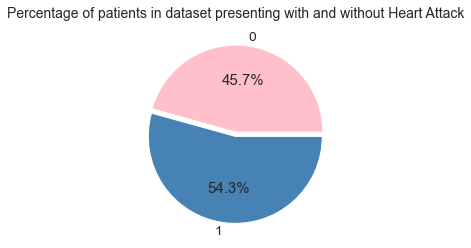

In [963]:
# Getting Percentage distribuition of "output" across the dataset
df_counts= data_HA.groupby(['output'])['age'].agg('count').reset_index(name="Count")


fig1, ax1 = plt.subplots()
sns.set(font_scale=1.25)
ax1.pie(df_counts['Count'],labels=df_counts['output'],colors =["pink","steelblue"], explode= (0,0.05),autopct = '%1.1f%%')
ax1.set_title('Percentage of patients in dataset presenting with and without Heart Attack',fontsize = 14)

#### 6. Exploratory Descriptive (Qualitative) Analysis:

#### 6.1 Discrete Attributes:
Let's use the function Stacked_Bar_Chart writed above to Look at the distribution of Discrete variables 

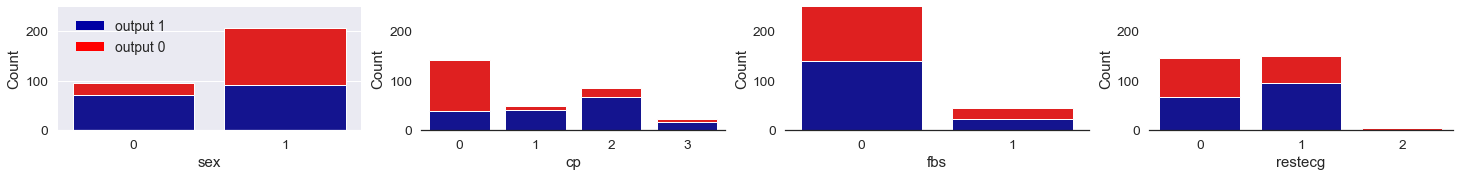

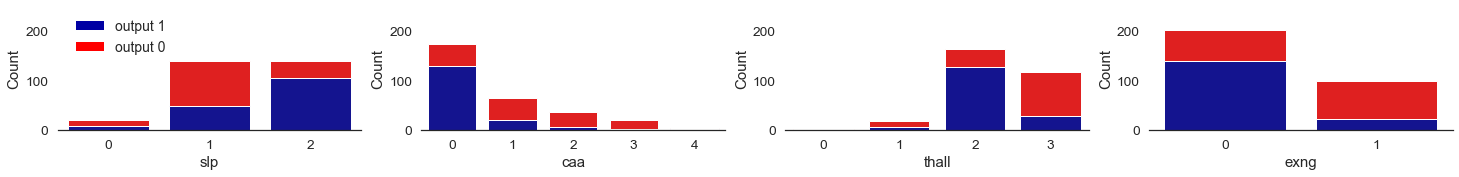

In [964]:

plt.subplots(figsize=(25, 5))
 
# adding first subplot
plt.subplot(241)
Stacked_Bar_Chart(data_HA, 'sex')     
 
# adding second subplot
plt.subplot(242)
Stacked_Bar_Chart(data_HA, 'cp')

plt.subplot(243)
Stacked_Bar_Chart(data_HA, 'fbs')

plt.subplot(244)
Stacked_Bar_Chart(data_HA, 'restecg')

# legend
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['output 1', 'output 0'], loc='upper left', ncol = 1, prop={'size':14}, bbox_to_anchor=(-3.58, 1))    # ['output 1 - No HA', 'output 0 - Yes HA']
l.draw_frame(False)

plt.subplots(figsize=(25, 5))
 
plt.subplot(241)
Stacked_Bar_Chart(data_HA, 'slp')

plt.subplot(242)
Stacked_Bar_Chart(data_HA, 'caa')

plt.subplot(243)
Stacked_Bar_Chart(data_HA, 'thall')

plt.subplot(244)
Stacked_Bar_Chart(data_HA, 'exng')

# legend
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['output 1', 'output 0'], loc='upper left', ncol = 1, prop={'size':14}, bbox_to_anchor=(-3.58, 1))    # ['output 1 - No HA', 'output 0 - Yes HA']
l.draw_frame(False)


#### 6.1.1 Summary of Results:

1. We can see that the Target variable, outcome, is affected by the discrete attributes like caa, cp, exng and slp. 

2. We can also see that demographic attribute like sex is not evenly distributes between the outcome groups. This may influence the importance of this attribute in term of its importance to the model we are trying to develop here.

#### 6.2 Continuous Attributes:

<AxesSubplot:xlabel='output', ylabel='o2Saturation'>

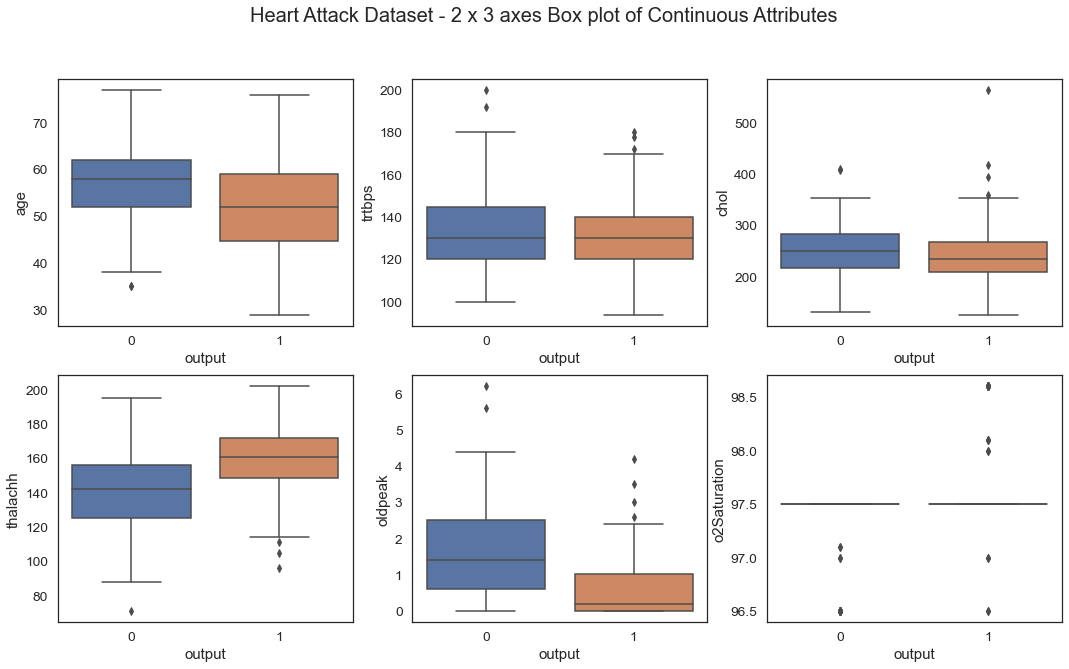

In [965]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
 
fig.suptitle('Heart Attack Dataset - 2 x 3 axes Box plot of Continuous Attributes', fontsize = 20)

#ax1.set_title('Percentage of patients presenting with Heart Attack',fontsize = 14)
  
sns.boxplot(ax=axes[0, 0], data=data_HA, x='output', y='age')
sns.boxplot(ax=axes[0, 1], data=data_HA, x='output', y='trtbps')
sns.boxplot(ax=axes[0, 2], data=data_HA, x='output', y='chol')
sns.boxplot(ax=axes[1, 0], data=data_HA, x='output', y='thalachh')
sns.boxplot(ax=axes[1, 1], data=data_HA, x='output', y='oldpeak')
sns.boxplot(ax=axes[1, 2], data=data_HA, x='output', y='o2Saturation')

From the graph above we could already appreciate attributes like age, thalachh (max heart rate achieved) and oldpeak having a potentail effect on the output, namely, Yes / No heart attach.  

#### 6.3 Bivariate & Univariate Distributions:
Let's use .pairplot() function to plot multiple pairwise bivariate distributions in the dataset. 
The diagonal plots are the univariate plots.

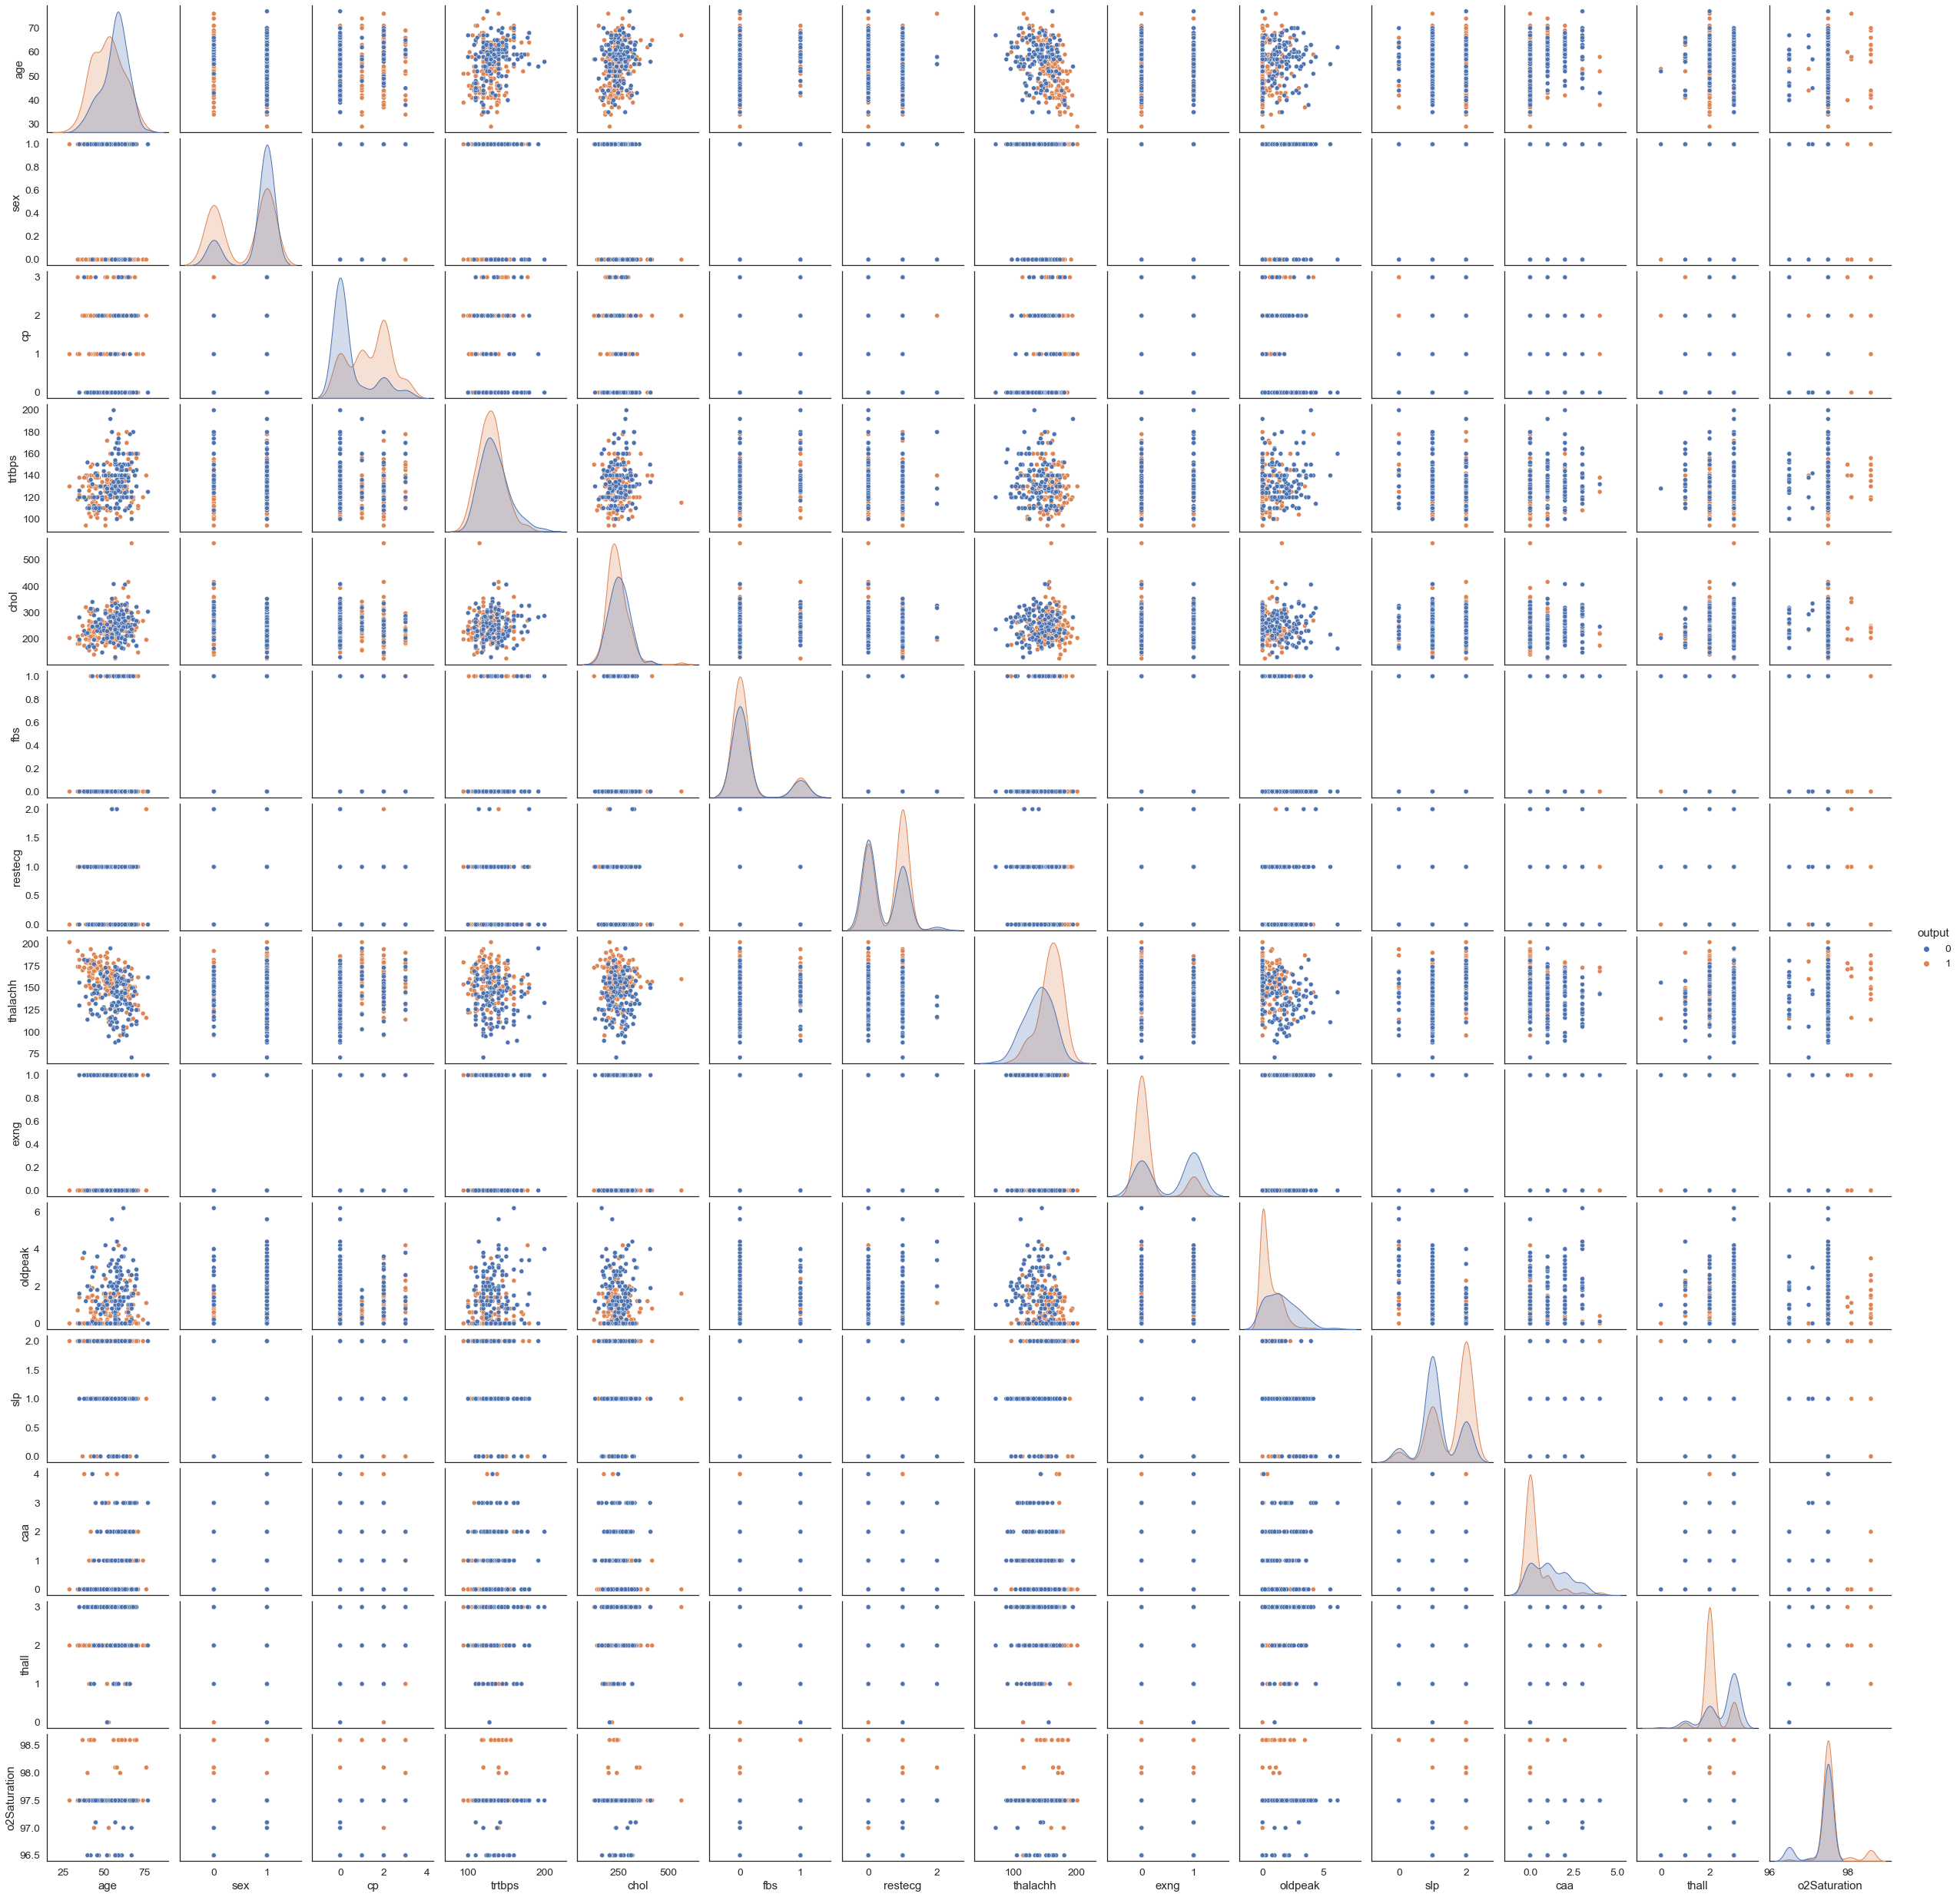

In [966]:
# pairplot with hue output
fig.suptitle('Heart Attack Dataset - 6 X 6 axes Histograms and scatter plots', fontsize = 20)
sns.pairplot(data_HA, hue ='output')
plt.show()

##### 6.3.1 Summary of Findings - Target Variable:

1. The findings in the figure above suggest that my initial interpretation of the Target variable (1 = Yes Heart Attach -> orange, and 0 = No Heart Attach -> blue) may have not been correct and 0 = Yes Heart Attach -> blue, while 1 = No Heart Attach -> orange

2. As a data scientist working in the healthcare domain, I would expect:

    A. o2Saturation (oxygen saturation) in patients presenting with Heart Attach be lower compared to patients that are not presenting with Heart Attach. The figure above suggests the opposite.
    
    B. Cholesterol in patients presenting with Heart Attach be higher compared to patients that are not presenting with Heart Attach. The figure above suggests the opposite.
    
    C. age of patients presenting with Heart Attach be higher (and the distribution narrower and more skewed) compared to patients that are not presenting with Heart Attach. The figure above suggests the opposite.
    
    D. thalachh (max heart rate achieved) measured in patients presenting with Heart Attach be lower compared to patients that are not presenting with Heart Attach. The figure above suggests the opposite.
    
    E. Heart Attach is mostly described by an elevated ST peak on the ECG, I am going to assume this is what's called here the oldpeak. Here 0 shows higher more spread values, while 1 depicts a nice narrow pick at low oldpeak values.

Therefore, the following graph is the right description of the Target Variable of the data:

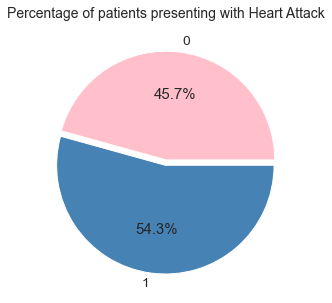

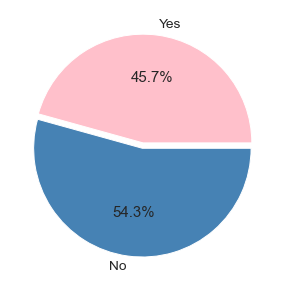

In [969]:
#Getting Percentage distribuition of "output" across the dataset

#df_counts= data_HA.groupby(['output'])['age'].agg('count').reset_index(name="Count")sns.scatterplot(data=df, x='petal_length', y='petal_width', ax=axes[1]);

fig1, ax1 = plt.subplots()
sns.set(font_scale=1.25)
ax1.pie(df_counts['Count'],labels=df_counts['output'],colors =["pink","steelblue"], explode= (0,0.05),autopct = '%1.1f%%')
ax1.set_title('Percentage of patients presenting with Heart Attack',fontsize = 14)

fig2, ax2 = plt.subplots()
ax2.pie(df['Value_Counts'],labels=df['Heart_Attack'],colors =["pink","steelblue"], explode= (0,0.05),autopct = '%1.1f%%')
#ax2.set_title('Percentage of patients presenting with Heart Attack',fontsize = 14)

plt.show()

##### 6.3.2 Summary of Findings - Univariate plots - Qualitative Analysis:
The univariate distribution is depicted using Kernel Density Estimation, a histogram that approximate the underlying probability density function using a Gaussian kernel to smooth the observations. 

We can see that the Target variable (Heart Attach: 0 - Yes  / 1 - No) has a visible effect on the probability density function of attributes like age, sex, cp (chest pain), restecg (resting ecg results), thalachh (max heart rate achieved), exng (exercise induced angina), oldpeak, slp (slope), caa (number of major vessels), thall (Thalium Stress Test) and o2Saturation (blood oxygen saturation).

##### 6.3.3 Summary of Findings - Bivariate plots - Continuous Attributes - Qualitative Analysis:

The scatter plots above suggest there may be correlation and codependency between attributes in the given dataset. 

Examples: 

   1. A negative correlation between age and thalachh (max heart rate achieved), while higher age and lower thalachh seem to result in a higher chance for a heart attach.  
        
   2. A positive correlation between age and trtbps (resting blood pressue), while higher age and higher trtbps seem to result in a higher chance for heart attach.
        
   3. A positive correlation between age and chol (Cholesterol),while higher age and higher chol seem to result in a higher chance for heart attach. 
        
   4. A positive correlation between trtbps and chol (Cholesterol), while higher trtbps values and higher chol values seem to result in a higher chance for heart attach.
        
   5. A negative correlation between oldpeak (previous peak) and thalachh (max heart rate achieved), while higher oldpeak values and lower thalachh values seem to result in a higher chance for a heart attach.

To quantify these relationships and their strength considering both discrete and continuous variables, please find Spearman correlation results in section 7 below.

### 7. Correlation and Codependency between Attributes - Quantitative Results: 

Let's use the .corr() function to find the correlation among the columns in the dataset using the Spearman correlation method. 

Since not all the variables in the dataset at hand are continuous, and given the bivariate distributions depicted above, we can not assume the shape of the relationship between the variables is linear. Therefore, we should use a nonparametric correlation technique, i.e., Spearman’s correlation.

https://www.surveymonkey.com/market-research/resources/pearson-correlation-vs-spearman-correlation/

In [970]:
# Calculate the coefficient and p-value using the function correlation_test() defined above:
spearman_stat, spearman_p = correlation_test(data_HA)

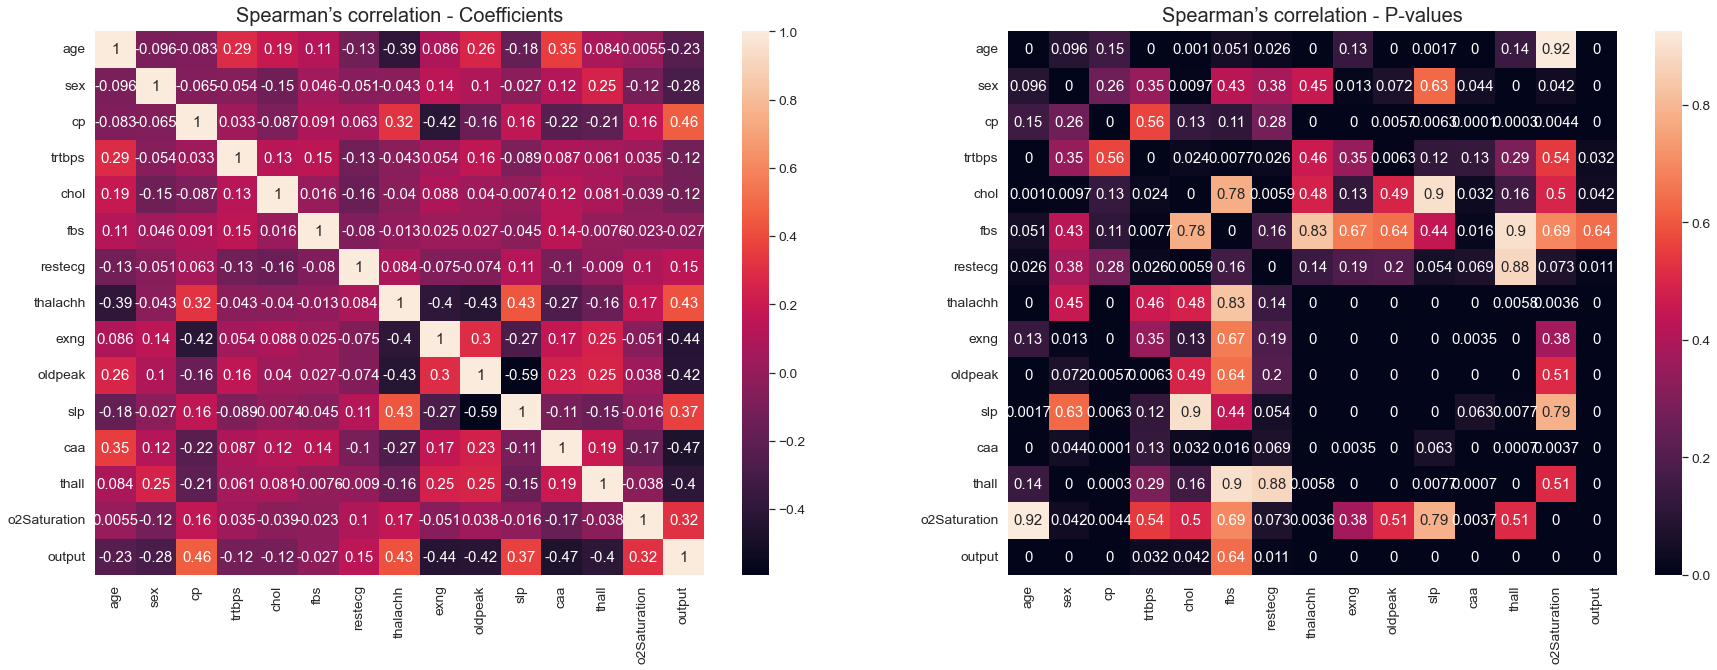

In [971]:
# Produce heatmaps using the function save_correlation_map() defined above: 
save_correlation_map(spearman_stat, spearman_p, 'Spearman’s_correlation_Heatmaps', 'Spearman’s correlation')

#### 7.1 Summary of Findings - Spearman’s Correlation Coefficient:

How to read the results:

    A Spearman’s correlation coefficient of between 0 and 0.3 (or 0 and -.3) indicates a weak monotonic relationship between the two variables.
    A Spearman’s correlation coefficient of between 0.4 and 0.6 (or -.4 and -.6) indicates a moderate strength monotonic relationship between the two variables.
    A Spearman’s correlation coefficient of between 0.7 and 1 (or -.7 and -1) indicates a strong monotonic relationship between the two variables.
    
    Any feature that has a p-value for another feature above 0.05 is deemed as uncorrelated with that feature.

Results: 

       1. The heatmap above depicts Spearman’s correlation coefficients in the weak and moderate range. 
       
       Noted here are the correlations in the moderate range (0.4 and 0.6 (or -.4 and -.6)):  
       
       Correlation between Features:
       ----------------------------
       2. Of particular interest is a rectangular-shaped region of interest between the attributes thalachh and thall (on both axes). 
       3. This mostly dark area deficts p-values of less than 0.005, indicating significant correlation between attributes. 
       4. Most prominently is the significant moderate correlationt between attributes connected to ECG measurement, suggesting codependency:   
          4.1 oldpeak and slp (coefficient = -0.59, p-value << 0.05), 
          4.2 oldpeak and thalachh (coefficient = -0.43, p-value << 0.05),
          4.3 thalachh and exng (coefficient = -0.40, p-value << 0.05),
          4.4 thalachh and slp (coefficient = 0.43, p-value << 0.05).
       5. Other interesting relationships are between:
          5.1 cp (chest pain) and exng (exercies induced angina) (coefficient = -0.42, p-value << 0.05),
          5.2 age and thalachh (max heart rate achieved) (coefficient = -0.39, p-value << 0.05).
          
       Correlation between feature-class and (class = Target variable):
       ---------------------------------------------------------------
       6. The heatmaps above show that the most significant feature - Target vraible correlations are (in coefficients descending order):
          6.1 caa (number of major vessels) - coefficient = -0.47, p-value << 0.05
          6.2 cp (chest pain) - coefficient = 0.46, p-value << 0.05
          6.3 exng (exercise induced angina) - coefficient = -0.44, p-value << 0.05
          6.4 thalachh (max heart rate achieved) - coefficient = 0.43, p-value << 0.05
          6.5 oldpeak (previous peak) - coefficient = -0.42, p-value << 0.05
          6.6 thall (Thalium Stress Test) - coefficient = -0.40, p-value << 0.05
       7. These quantitative results support the qualitative trends demostrated by the univariate distributions depicted on the diagonal of the pairwise plote above.
          
Conclusions: 

        1. The above results suggest codependency between some of the attributes in the dataset. 
        2. The attributes caa, cp, exng, thalachh, oldpeak and thall have been pinpointed as the most predictive attributes in the dataset. 
        
Next Steps:

        1. When preparing data for ML, the goal is to find a feature subset with low feature-feature correlation, to avoid redundancy, and high feature-class correlation to maintain or increase predictive power.
        2. Since significance moderate relationships were detected, we will use feature selection algoritm in skitlean to choose the best set of parametrs for our heart attach predictive model. Please see next section. 


### 8. Feature Selection: 



#### 8.1 Further data preprocessing steps:

A note: In general, feature selection techniques are used when a dataset has tens of even hundreds of attributes / features. To deploy a model, we aim to find the most significant ones to have as compact and as efficient model as possible. The dataset at hand has 14 features (and one Target variable). Hence, in this case I am going ahead with the feature selection part mostly for demonstration purposes. I don’t expect a “wow” effect here, as the number of attributes is relatively small to begin with. 

##### 8.1.1 Categorical Features - Typecast

In [972]:
# typecast categorical features as such:
categorical_lst = ['sex', 'cp', 'restecg', 'fbs', 'exng', 'slp', 'caa', 'thall']
data_HA[categorical_lst] = data_HA[categorical_lst].astype('category')

data_HA.dtypes

age                int32
sex             category
cp              category
trtbps           float64
chol             float64
fbs             category
restecg         category
thalachh           int32
exng            category
oldpeak          float64
slp             category
caa             category
thall           category
o2Saturation     float64
output             int32
dtype: object

##### 8.1.2 Continuous Features - Normalization:
This step's objective is to scale the dimensions of all continuous attributes where all values will range between 0 and 1.

In [973]:
# List of continuous attributes:
continuous_lst = list(set(data_HA[data_HA.columns[:-1]].columns) - set(categorical_lst))
continuous_lst

['age', 'chol', 'o2Saturation', 'trtbps', 'thalachh', 'oldpeak']

In [974]:
# Use MinMaxScaler() from sklearn.preprocessing (X - X_Min) / (X_Max - X_Min):
scaler = MinMaxScaler()
# Using all attributes but the target variable, output:
data_HA_norm = data_HA[data_HA.columns[:-1]].copy()
data_HA_norm[continuous_lst] = scaler.fit_transform(data_HA[continuous_lst])

In [975]:
print(data_HA_norm.shape)
data_HA_norm.head(3)

(302, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,o2Saturation
0,0.708333,1,3,0.481132,0.244292,1,0,0.603053,0,0.370968,0,0,1,1.0
1,0.166667,1,2,0.339623,0.283105,0,1,0.885496,0,0.564516,0,0,2,1.0
2,0.250000,0,1,0.339623,0.178082,0,0,0.770992,0,0.225806,2,0,2,1.0


##### 8.1.3 Target Variable - Class Attribute:

In [976]:
target_var = data_HA[data_HA.columns[-1]]

##### 8.1.4 Split data in train and test set:

In [977]:
# Split the dataset into train (80%) and test (20%) data:
X_train, X_test, y_train, y_test = train_test_split(data_HA_norm, target_var, test_size=0.2, stratify=target_var, random_state=42)  

##### 8.1.5 Saving features's names:

In [978]:
feature_names = data_HA_norm.columns

#### 8.2 SelectKBest for Classification using Chi-Square Test:

https://lifewithdata.com/2022/03/19/feature-selection-with-selectkbest-in-scikit-learn/

In [979]:
## Use SelectKBest and chi2 from sklearn.feature_selection:    
# k = #  of selected features, 
# score_func: the function on which the selection process is based upon. 

select_chi =  SelectKBest(k=10, score_func=chi2)
select_chi.fit(X_train, y_train)    # [categorical_lst]           
X_new = select_chi.transform(X_train)  # [categorical_lst]
X_new.shape

(241, 10)

In [980]:
kept_features = pd.DataFrame({'Columns': data_HA_norm.columns, 'Scores': select_chi.scores_,
                              'Kept': select_chi.get_support()}) # [categorical_lst]

kept_features.sort_values(by = ['Scores'], inplace=True, ascending=False)
kept_features.reset_index(drop=True, inplace=True)
kept_features

,Columns,Scores,Kept
0,cp,58.256949,True
1,caa,47.761985,True
2,exng,32.144487,True
3,oldpeak,10.542221,True
4,slp,9.254951,True
5,thall,5.245402,True
6,sex,4.577377,True
7,restecg,2.854597,True
8,thalachh,1.981335,True
9,o2Saturation,1.510813,True


#### 8.3 Feature Selection Using Random Forest:
Tree-based models can calculate how much important a feature is by calculating the amount of impurity (or in enother word disorder) decrease this feature will lead to by using measures like entropy (namely reduce entropy / recude impurity / increase order). 
https://www.javatpoint.com/entropy-in-machine-learning 

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#:~:text=RandomForestClassifier%20%28random_state%3D0%29%20Feature%20importance%20based%20on%20mean%20decrease,accumulation%20of%20the%20impurity%20decrease%20within%20each%20tree.

https://www.freecodecamp.org/news/how-to-use-the-tree-based-algorithm-for-machine-learning/#:~:text=The%20algorithm%20can%20be%20used%20to%20solve%20both,by%20averaging%20the%20predictions%20of%20each%20individual%20tree.

In [981]:
forests = RandomForestClassifier(n_estimators=100, random_state=0) 
forests.fit(X_train, y_train)  

RandomForestClassifier(random_state=0)

In [982]:
importances = forests.feature_importances_
std = np.std([tree.feature_importances_ for tree in forests.estimators_], axis=0)
std_error = std / np.sqrt(len(forests.estimators_))

In [983]:
d_forest = {'feature_name': forests.feature_names_in_, 'forest_importances': importances, 'std_error': std_error}
df_forest = pd.DataFrame(d_forest).round(3)
df_forest.sort_values(by = ['forest_importances'], inplace=True, ascending=False)
df_forest.reset_index(drop=True, inplace=True)
df_forest

,feature_name,forest_importances,std_error
0,cp,0.145,0.011
1,thall,0.118,0.010
2,thalachh,0.113,0.008
3,oldpeak,0.109,0.008
4,chol,0.081,0.004
5,caa,0.080,0.007
6,age,0.076,0.005
7,trtbps,0.069,0.004
8,exng,0.068,0.008
9,slp,0.046,0.005


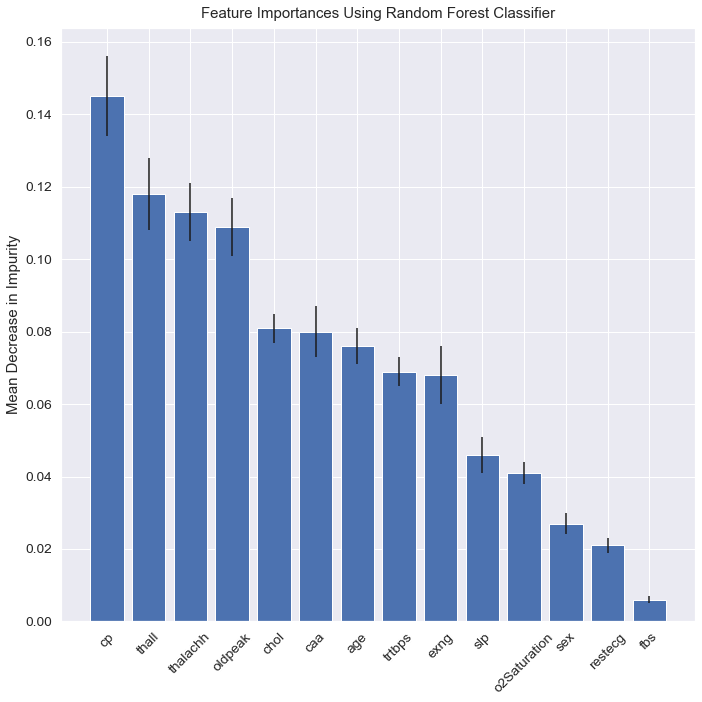

In [984]:
# Let’s plot the impurity-based importance:

forest_importances = pd.Series(df_forest.forest_importances, index=df_forest.feature_name)

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(df_forest.feature_name, df_forest.forest_importances, yerr=df_forest.std_error) 
ax.set_title("Feature Importances Using Random Forest Classifier", pad = 10)
ax.set_ylabel("Mean Decrease in Impurity")
plt.xticks(rotation=45)
fig.tight_layout()

#### 8.4 Summary of Findings - Feature Selection:

1. Given feature importances results using the random forest classifier on the training data and the Spearman’s Correlation results detailed on section 7 above, here are the most imporant features accoring to my current analysis:

     cp (chest pain), thalachh (max heart rate achieved), thall (Thalium Stress Test), oldpeak (previous peak), caa (number of major vessels), age, trtbps (resting blood pressue), chol (Cholesterol) and exng (exercise induced angina). 

2. slp is correlated (dependent) with both oldpeak (strongest correlation in the dataset of -0.59 p <<0.05) and thalachh. 

3. 02Saturation, sex, restecg and fbs, show even lower importance and no significant feature-class correlation in section 7 above.

### Modeling - Building A Classification Model

#### 1. Build a Machine Learning Model Pipeline:
In this analysis, we are going to test four models that fit a classification problem with a Categorical response: 

1. Random Forest, 2. Gaussian Naive Bayes, and 3. Support Vector Machine (SVM), 4. Gradient Boosting.

https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501

In [985]:
model_pipeline = []
model_pipeline.append(RandomForestClassifier(n_estimators=100, random_state=0))
model_pipeline.append(GaussianNB())
model_pipeline.append(SVC(random_state=0, kernel = 'linear'))
model_pipeline.append(GradientBoostingClassifier(n_estimators=100, random_state=0))

model_lst = ['Random Forest', 'Naive Bayes', 'SVM', 'GBC']
cv_scores_mean = []  # cross validation
accuracy_lst = []
FPR_lst = []         # False Positive Rate
TPR_lst = []         # True Positive Rate
sensitivity_lst = []          
specificity_lst = []  
ppv_lst = []         # positive predictive value
FP_lst = []          # False Positive
TN_lst = []          # True Negative
auc_lst = []         # auc stands for Area Under the Curve
cm_lst = []          # cm stabds for Confusion Matrix
cr_lst = []          # cr = classification report

#### 2. Models Evaluation:

##### 2.1 Accuracy and AUC results:

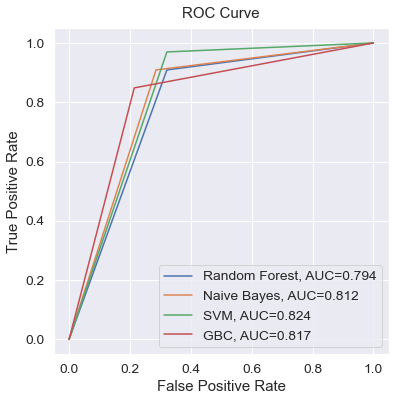

In [986]:
fig = plt.figure(figsize = (6, 6))

for i, model in enumerate(model_pipeline):
    # fit the model on training data:
    model.fit(X_train, y_train)
    # Measure accuracy on training data using cross validation (average of leave one out):
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    cv_scores_mean.append(round(cv_scores.mean(),3))
    
    # predict on test set:
    y_pred = model.predict(X_test)
    
    # append to accuracy list:
    acc = round(metrics.accuracy_score(y_test, y_pred),3)
    accuracy_lst.append(acc)
    # Calculation False Positive Rate (FPR), True Positive Rate (TPR) and corresponding thresholds array so we could build The ROC Curve:
    FPR, TPR, _thresholds = metrics.roc_curve(y_test, y_pred)
    # populating the auc_list:
    auc = round(metrics.auc(FPR, TPR),3)
    auc_lst.append(auc)
    # populating the cm_lst:
    cm = confusion_matrix(y_test, y_pred)
    cm_lst.append(cm)
    # Confusion Matrix Param:
    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    
    sensitivity_lst.append(round(TP/(TP+FN),3))     # sensitivity => TPR True Positive Rate
    specificity_lst.append(round(TN/(FP+TN),3))     # specificity => TNR True Negative Rate
    ppv_lst.append(round(TP/(TP+FP),3))             # precision   => PPV positive predictive value   
    
    # populating the cr_lst:
    target_names = ['class 0', 'class 1']
    cr_lst.append(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
    
    #create ROC curve:
    plt.plot(FPR,TPR,label=model_lst[i] +", AUC="+str(auc))

plt.title('ROC Curve', pad = 10)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

##### 2.2 Plot Heatmap to describe Confusion Matric:

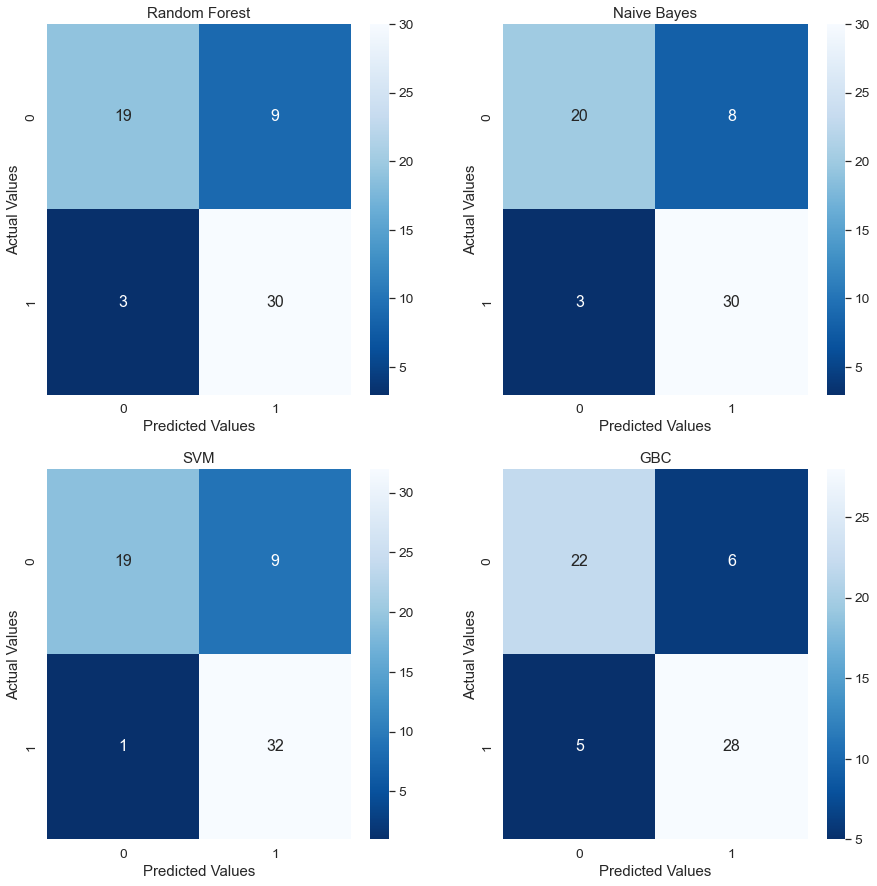

In [987]:
fig = plt.figure(figsize = (15, 15))
for i in range(len(cm_lst)):
    cm = cm_lst[i]
    model = model_lst[i]
    subplt = fig.add_subplot(2,2, i+1).set_title(model)
    cm_hm = sns.heatmap(cm, cmap = 'Blues_r', annot=True, annot_kws={"fontsize":16})
    cm_hm.set_xlabel('Predicted Values')
    cm_hm.set_ylabel('Actual Values')

##### 2.3 Summary of Results:

In [988]:
results_df = pd.DataFrame({'Model': model_lst, 'CV Mean Score': cv_scores_mean, 'Accuracy-predict': accuracy_lst, 'AUC': auc_lst, 'Sensitivity-cl0': sensitivity_lst, 'Specificity-cl0': specificity_lst, 'PPV-cl0': ppv_lst})
results_df.sort_values(by = ['Accuracy-predict', 'AUC'], inplace=True, ascending=False)
results_df

,Model,CV Mean Score,Accuracy-predict,AUC,Sensitivity-cl0,Specificity-cl0,PPV-cl0
2,SVM,0.859,0.836,0.824,0.679,0.970,0.950
3,GBC,0.813,0.820,0.817,0.786,0.848,0.815
1,Naive Bayes,0.826,0.820,0.812,0.714,0.909,0.870
0,Random Forest,0.813,0.803,0.794,0.679,0.909,0.864


#### 3. The Chosen Model - SVM:

In [989]:
score = svc.score(X_train, y_train)
print("Score: ", score)

cv_scores = cross_val_score(svc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = svc.predict(X_test)

cm = confusion_matrix(y_test, ypred)
print(cm)

cr = classification_report(y_test, ypred)
print(cr) 

Score:  0.8921161825726142
CV average score: 0.86
[[19  9]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



#### 4. Summary of Results:

Results:

1. Predicting the likelihood of a Heart Attack (class 0), the results presented graphically and numerically show that SVM is the most accurate, specific and precise model out of the four models tested. 
    1.1 The mean accuracy produced using cross validation is the highest,
    1.2 The ratio between TPR and FPR on the ROC curve is the closest to 1 and the AUC (area under the curve) is the highest. 

2. The SVM model presents a small type I error, namely low false alarm compared to the other three models, therefore its high PPV (also called precision).

3. It's sensitivity, however, is not as high (0.68). This is a result of its relatively high type II error. It means that this model has a higher chance of missing a positive case of Heart Attack. It's sensitivity to a negative case of Heart Attack, on the other hand, is high (0.97). 


Conclusions:

1. PPV is one of the most important measures of a model or a medical device performance in clinical settings; doctors would often ask to know this measure first. From my experience, institutes like the FDA would also find this crucial to approve a data science product in the healthcare / medical devices industry. 

2. The lower sensitivity of the model/s presented here may result from:

    2.1 Low N of 302, N being the number of patients in the dataset. This is considered a small dataset. More data acquisition is required to improve the model's sensitivity. 
    
    2.2 The percentage of patients presenting with and without Heart Attack is not balanced, while there are about 18% less patients with Heart Attack (Target variable / class 0).  

### Questions:

### A. Model Production:
https://www.frontiersin.org/articles/10.3389/fdata.2018.00007/full

1. In order to put the chosen sklearn SVM model into production we would need a platforms like:
    
    
    1.1  Google's Cloud ML Engin: 
    https://cloud.google.com/ai-platform/prediction/docs/ml-predictions-scikit-xgboost-models    .

    
    1.2 AWS: 
    https://towardsdatascience.com/deploying-a-scikit-learn-model-on-aws-using-sklearn-estimators-local-jupyter-notebooks-and-the-d94396589498    .
    
   
   1.3 There are many other options on the market including platforms that are dedicated to the deployment of healthcare models at scale. Those, however, are more costly solutions. 
   
    
2. In order to do that we first need to Export the classifier to a file as seen in the code below:    

In [990]:
import joblib

# Export the classifier to a file
joblib.dump(svc, 'model.joblib')    # svc is our trained classifier as detailed above

['model.joblib']

Next step .... upload the model.joblib file to Google Cloud or AWS Storage. The specific steps depands on the platform used.

#### Test the Model in Production:

We could pull one random sample row from our data, the Target variable is known. We’ll present the data to the deployed modle as a simple array, encoded as a json file.
For example, see the code below. Here I’m taking the test features dataframe and extracting row 10 row from it, and then calling .values to get the underlying numpy array:

In [991]:
print(list(X_test.iloc[10:11].values))

[array([0.5       , 1.        , 0.        , 0.45283019, 0.2283105 ,
       0.        , 0.        , 0.30534351, 1.        , 0.        ,
       2.        , 0.        , 3.        , 0.47619048])]


In [992]:
y_pred_test = svc.predict(list(X_test.iloc[10:11].values))
y_pred_test

array([0])

In [993]:
y_test.iloc[10:11].values

array([1])

We chose a random example that demonstrates type II error in the chosen model - namely underestimation / missing a case of Hearth Attach.  

#### Information I would require from my colleagues on the Engineering team:
    
    1. Which platform are we using to save the data?
    
    2. Are we using "live" data (updated continuously) or are we using a REST API (occasional dumps)? 
    
    3. Personal Health Information (PHI): Are HIPPA regulations already in place? Does the application chosen for deployment fulfill patients' privacy requirements?   
    
    4. What would be your platform of choice for R&D (open source, for example) and deployment (costs are involved, PHI requirements: these applications require a budge)?    
    
As a team we would need to decide:

    3. Should we design an automatic preprocessing pipeline for cleaning data and feeding it to a warehouse / database ready for analysis? 
    
    4. Are we going to work locally or on the cloud? When would it be the right time to deploy a model at scale? 
        
    3. Which platform should we use to upload / store the model? Should it be the same system as the one used to store the the data / warehouse? 
    
    4. How can we increase / improve data acquisition to increase sensitivity of the model so we do not miss cases of Heart Attach, a challenge recognized by the current analysis.  

### B. Adding 10 min of continuous ECG data for each of the patients in the dataset - How would it change my approuch?

1. Adding 10 min of ECG data for each patient in the dataset would create a time series classification problem.

2. In the EDA I would add another preprocessing step where each ECG would be normalized between its max and min values.

3. Since the shape of an ECG recorded in patients presenting with and without a heart attack have distinct different shapes, the Shapelet-Based Classifiers may be a relevant approach for classification. Shapelets are subsequences, or small sub-shapes of time series that are representative of a class.

4. To achieve that I would experiment with a python package called sktime that extends the scikit-learn API to time series tasks.

https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55

https://www.researchgate.net/publication/301856632_The_Great_Time_Series_Classification_Bake_Off_An_Experimental_Evaluation_of_Recently_Proposed_Algorithms_Extended_Version